In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel # Using AutoModel for embeddings
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os

In [2]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

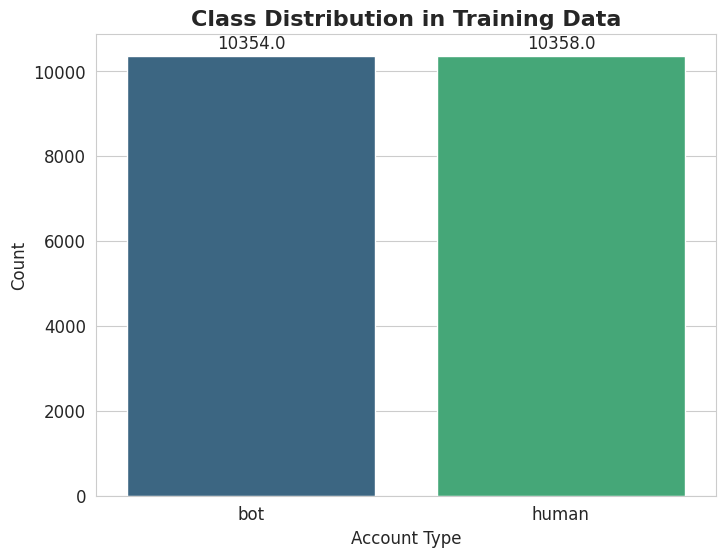

In [3]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

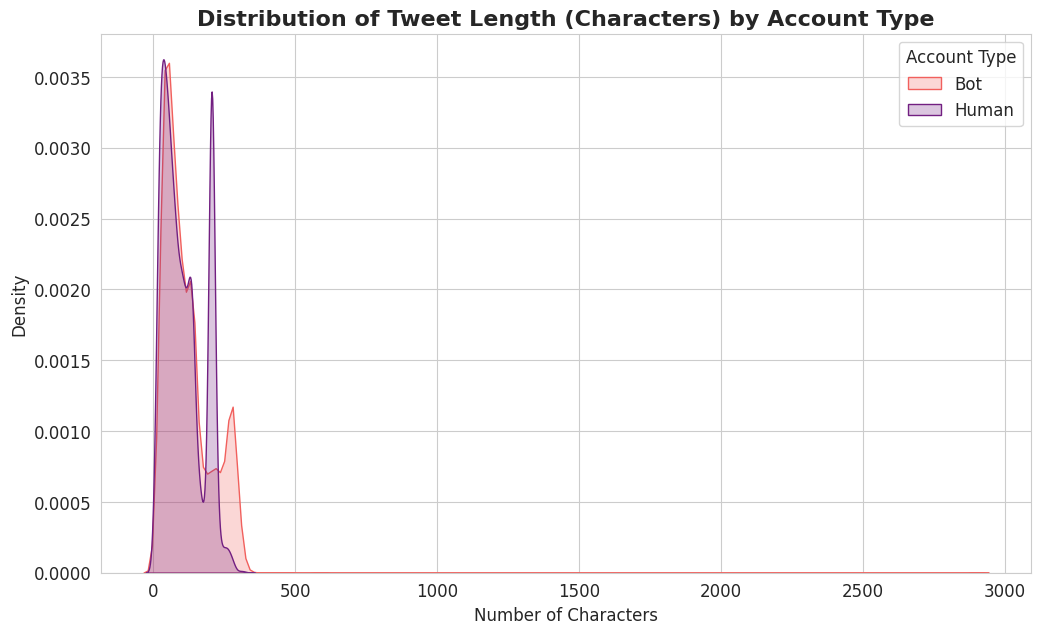

In [4]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

In [5]:
df_bots = df[df['account.type'] == 'bot']
df_bots.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2,92


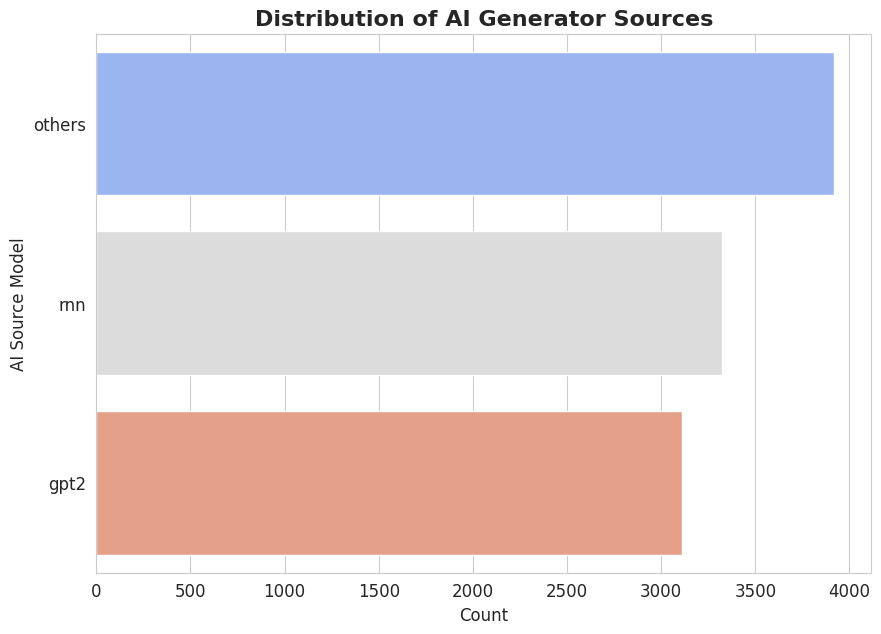

In [6]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [7]:
# --- 0. Configuration & Seeding ---
SEED = 42
ROBERTA_MODEL_NAME = "roberta-base"
MAX_LEN_ROBERTA = 128
BATCH_SIZE = 16 # Adjust as needed
EPOCHS_CNN_HYBRID = 4 # Similar to other RoBERTa fine-tuning, 3-5 epochs
LEARNING_RATE_CNN_HYBRID = 2e-5
NUM_CNN_FILTERS = 100       # Number of filters (output channels) for each kernel size
CNN_KERNEL_SIZES = [3, 4, 5] # List of kernel sizes (like n-gram window sizes)
CNN_DROPOUT_RATE = 0.3    # Dropout after CNN/pooling
OUTPUT_DIR_ROBERTA_CNN = "./roberta_cnn_hybrid_output"

if not os.path.exists(OUTPUT_DIR_ROBERTA_CNN):
    os.makedirs(OUTPUT_DIR_ROBERTA_CNN)

In [8]:
def seed_everything(seed=SEED): # Use the global SEED
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [9]:
# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# --- 2. Load Data (Assuming df_train_orig, df_val_orig, df_test_orig are loaded) ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

In [11]:
# --- 3. Basic Text Cleaning ---
def clean_text_for_roberta(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text)
    text = text.lower().strip()
    return text

df_train_orig['processed_text'] = df_train_orig['text'].apply(clean_text_for_roberta)
df_val_orig['processed_text'] = df_val_orig['text'].apply(clean_text_for_roberta)
df_test_orig['processed_text'] = df_test_orig['text'].apply(clean_text_for_roberta)

In [12]:
# --- 4. Label Encoding ---
label_mapping = {'human': 0, 'bot': 1}
num_labels_cnn_hybrid = len(label_mapping)
df_train_orig['label_encoded'] = df_train_orig['account.type'].map(label_mapping)
df_val_orig['label_encoded'] = df_val_orig['account.type'].map(label_mapping)
df_test_orig['label_encoded'] = df_test_orig['account.type'].map(label_mapping)

# Filter empty strings (ensure this uses the 'processed_text' column)
df_train_orig = df_train_orig[df_train_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_val_orig = df_val_orig[df_val_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_test_orig = df_test_orig[df_test_orig['processed_text'].str.strip() != ""].reset_index(drop=True)

In [13]:
# --- 5. RoBERTa Tokenizer ---
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [14]:
# --- 6. Tokenization Function ---
def tokenize_data_roberta(texts, labels, tokenizer, max_len):
    encodings = tokenizer(
        list(texts), truncation=True, padding=True, max_length=max_len, return_tensors="pt"
    )
    return encodings, torch.tensor(labels.values, dtype=torch.long)

train_encodings_cnn, train_labels_cnn = tokenize_data_roberta(df_train_orig['processed_text'], df_train_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
val_encodings_cnn, val_labels_cnn = tokenize_data_roberta(df_val_orig['processed_text'], df_val_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
test_encodings_cnn, test_labels_cnn = tokenize_data_roberta(df_test_orig['processed_text'], df_test_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)


In [15]:
# --- 7. Create TensorDatasets and DataLoaders ---
train_dataset_cnn = TensorDataset(train_encodings_cnn['input_ids'], train_encodings_cnn['attention_mask'], train_labels_cnn)
val_dataset_cnn = TensorDataset(val_encodings_cnn['input_ids'], val_encodings_cnn['attention_mask'], val_labels_cnn)
test_dataset_cnn = TensorDataset(test_encodings_cnn['input_ids'], test_encodings_cnn['attention_mask'], test_labels_cnn)

train_dataloader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Start with num_workers=0
val_dataloader_cnn = DataLoader(val_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders for RoBERTa+CNN created.")

DataLoaders for RoBERTa+CNN created.


In [16]:
# --- 8. Model Definition: RoBERTa + CNN ---
class RobertaCNNModel(nn.Module):
    def __init__(self, roberta_model_name, num_classes, num_cnn_filters, cnn_kernel_sizes, cnn_dropout_rate):
        super(RobertaCNNModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size # This is the embedding dim for CNN

        # Conv1d expects (batch_size, channels_in, sequence_length)
        # RoBERTa output is (batch_size, sequence_length, channels_in)
        # So we'll permute it in the forward pass.
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=roberta_output_dim,
                      out_channels=num_cnn_filters,
                      kernel_size=ks)
            for ks in cnn_kernel_sizes
        ])
        
        self.dropout = nn.Dropout(cnn_dropout_rate)
        # The input to the fully connected layer will be num_cnn_filters * len(cnn_kernel_sizes)
        # because we concatenate the outputs of the max-pooling layers for each kernel size.
        self.classifier = nn.Linear(len(cnn_kernel_sizes) * num_cnn_filters, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        # sequence_output shape: (batch_size, sequence_length, roberta_hidden_size)
        sequence_output = roberta_outputs.last_hidden_state
        
        # Permute to fit Conv1d: (batch_size, roberta_hidden_size, sequence_length)
        embedded_permuted = sequence_output.permute(0, 2, 1)
        
        # Apply convolutions and ReLU, then max pooling
        # conved[n] shape after conv: (batch_size, num_cnn_filters, sequence_length - kernel_sizes[n] + 1)
        # pooled[n] shape after pool: (batch_size, num_cnn_filters)
        conved = [F.relu(conv(embedded_permuted)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conved]
        
        # Concatenate the pooled features from different kernel sizes
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat shape: (batch_size, num_cnn_filters * len(cnn_kernel_sizes))
        
        logits = self.classifier(cat)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model_roberta_cnn = RobertaCNNModel(
    roberta_model_name=ROBERTA_MODEL_NAME,
    num_classes=num_labels_cnn_hybrid,
    num_cnn_filters=NUM_CNN_FILTERS,
    cnn_kernel_sizes=CNN_KERNEL_SIZES,
    cnn_dropout_rate=CNN_DROPOUT_RATE
).to(device)
print("RoBERTa + CNN model defined.")

2025-06-11 02:43:44.968367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749609825.165811      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749609825.223820      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa + CNN model defined.


In [17]:
# --- 9. Optimizer ---
optimizer_roberta_cnn = AdamW(model_roberta_cnn.parameters(), lr=LEARNING_RATE_CNN_HYBRID)

In [18]:
def train_model_generic(model, train_loader, val_loader, optimizer, device, epochs, model_save_path_base_dir, model_name_prefix, experiment_name_suffix=""):
    criterion = nn.CrossEntropyLoss()
    best_val_f1 = 0.0
    best_model_path = ""
    history = {'epoch': [], 'train_avg_loss': [], 'val_avg_loss': [], 'val_f1_score': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [{experiment_name_suffix} Train]", leave=False)

        for batch in train_progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs["loss"] if isinstance(outputs, dict) and "loss" in outputs and outputs["loss"] is not None \
                   else criterion(outputs["logits"] if isinstance(outputs, dict) else outputs, labels)
            
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - {experiment_name_suffix} Train Avg Loss: {avg_train_loss:.4f}")

        val_accuracy, val_f1, avg_val_loss = evaluate_model_generic(model, val_loader, device, f"{experiment_name_suffix} Validation")
        
        history['epoch'].append(epoch + 1); history['train_avg_loss'].append(avg_train_loss)
        history['val_avg_loss'].append(avg_val_loss); history['val_f1_score'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            current_model_save_path = os.path.join(model_save_path_base_dir, f"{model_name_prefix}_epoch{epoch+1}_f1_{val_f1:.4f}.pt")
            torch.save(model.state_dict(), current_model_save_path)
            best_model_path = current_model_save_path
            print(f"New best F1: {best_val_f1:.4f}. Model saved to {best_model_path}")

    history_df = pd.DataFrame(history)
    print(f"Training complete for {experiment_name_suffix}. Best validation F1: {best_val_f1:.4f} from {best_model_path}")
    return best_model_path, history_df

In [19]:
def evaluate_model_generic(model, dataloader, device, dataset_name="Dataset"):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    all_preds, all_labels, total_eval_loss = [], [], 0

    with torch.no_grad():
        eval_progress_bar = tqdm(dataloader, desc=f"Evaluating on {dataset_name}", leave=False)
        for batch in eval_progress_bar:
            input_ids, attention_mask, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs["loss"] if isinstance(outputs, dict) and "loss" in outputs and outputs["loss"] is not None \
                   else criterion(outputs["logits"] if isinstance(outputs, dict) else outputs, labels)
            logits = outputs["logits"] if isinstance(outputs, dict) else outputs

            total_eval_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_eval_loss = total_eval_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n--- {dataset_name} Results ---"); print(f"Avg Loss: {avg_eval_loss:.4f}"); print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}"); print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()));
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'{dataset_name} Confusion Matrix'); plt.show()
    return accuracy, f1, avg_eval_loss



--- Starting Experiment 4: RoBERTa + CNN Hybrid ---


Epoch 1/4 [RoBERTa-CNN Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 1 - RoBERTa-CNN Train Avg Loss: 0.4094


Evaluating on RoBERTa-CNN Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN Validation Results ---
Avg Loss: 0.3345
Accuracy: 0.8410
F1-Score (Weighted): 0.8407
              precision    recall  f1-score   support

       human       0.87      0.80      0.83      1143
         bot       0.82      0.88      0.85      1152

    accuracy                           0.84      2295
   macro avg       0.84      0.84      0.84      2295
weighted avg       0.84      0.84      0.84      2295



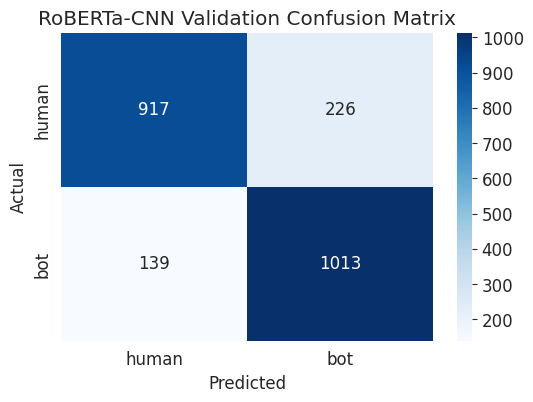

New best F1: 0.8407. Model saved to ./roberta_cnn_hybrid_output/roberta_cnn_hybrid_epoch1_f1_0.8407.pt


Epoch 2/4 [RoBERTa-CNN Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 2 - RoBERTa-CNN Train Avg Loss: 0.2799


Evaluating on RoBERTa-CNN Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN Validation Results ---
Avg Loss: 0.3199
Accuracy: 0.8505
F1-Score (Weighted): 0.8504
              precision    recall  f1-score   support

       human       0.87      0.82      0.84      1143
         bot       0.83      0.88      0.86      1152

    accuracy                           0.85      2295
   macro avg       0.85      0.85      0.85      2295
weighted avg       0.85      0.85      0.85      2295



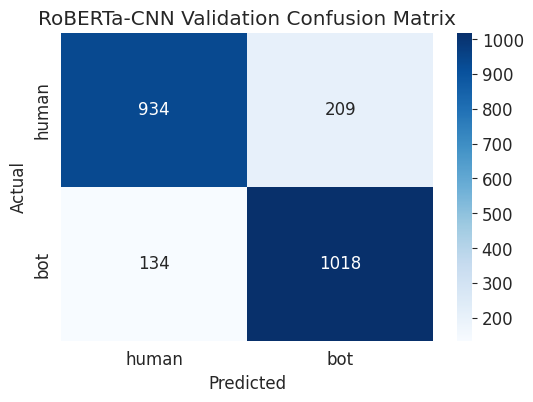

New best F1: 0.8504. Model saved to ./roberta_cnn_hybrid_output/roberta_cnn_hybrid_epoch2_f1_0.8504.pt


Epoch 3/4 [RoBERTa-CNN Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 3 - RoBERTa-CNN Train Avg Loss: 0.1895


Evaluating on RoBERTa-CNN Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN Validation Results ---
Avg Loss: 0.3628
Accuracy: 0.8484
F1-Score (Weighted): 0.8483
              precision    recall  f1-score   support

       human       0.83      0.87      0.85      1143
         bot       0.87      0.82      0.84      1152

    accuracy                           0.85      2295
   macro avg       0.85      0.85      0.85      2295
weighted avg       0.85      0.85      0.85      2295



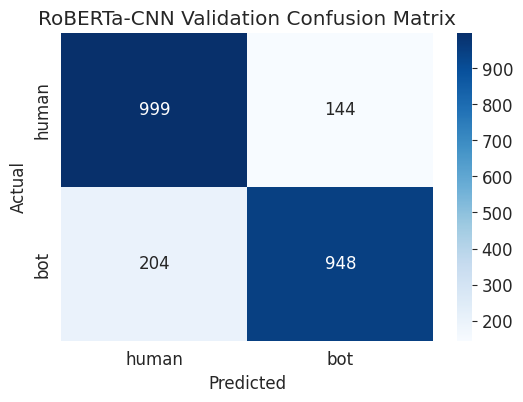

Epoch 4/4 [RoBERTa-CNN Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 4 - RoBERTa-CNN Train Avg Loss: 0.1224


Evaluating on RoBERTa-CNN Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN Validation Results ---
Avg Loss: 0.3823
Accuracy: 0.8540
F1-Score (Weighted): 0.8540
              precision    recall  f1-score   support

       human       0.84      0.87      0.86      1143
         bot       0.87      0.84      0.85      1152

    accuracy                           0.85      2295
   macro avg       0.85      0.85      0.85      2295
weighted avg       0.85      0.85      0.85      2295



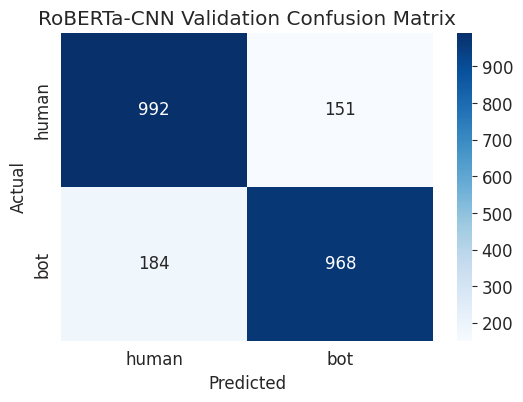

New best F1: 0.8540. Model saved to ./roberta_cnn_hybrid_output/roberta_cnn_hybrid_epoch4_f1_0.8540.pt
Training complete for RoBERTa-CNN. Best validation F1: 0.8540 from ./roberta_cnn_hybrid_output/roberta_cnn_hybrid_epoch4_f1_0.8540.pt

RoBERTa-CNN Hybrid Training History:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.409399      0.334456      0.840706      0.840959
1      2        0.279884      0.319932      0.850366      0.850545
2      3        0.189505      0.362821      0.848278      0.848366
3      4        0.122357      0.382317      0.854009      0.854031

Loading best RoBERTa-CNN Hybrid model from: ./roberta_cnn_hybrid_output/roberta_cnn_hybrid_epoch4_f1_0.8540.pt

--- Testing RoBERTa-CNN Hybrid on Test Set (with best model) ---


Evaluating on RoBERTa-CNN Test:   0%|          | 0/160 [00:00<?, ?it/s]


--- RoBERTa-CNN Test Results ---
Avg Loss: 0.3793
Accuracy: 0.8588
F1-Score (Weighted): 0.8588
              precision    recall  f1-score   support

       human       0.85      0.87      0.86      1270
         bot       0.87      0.85      0.86      1280

    accuracy                           0.86      2550
   macro avg       0.86      0.86      0.86      2550
weighted avg       0.86      0.86      0.86      2550



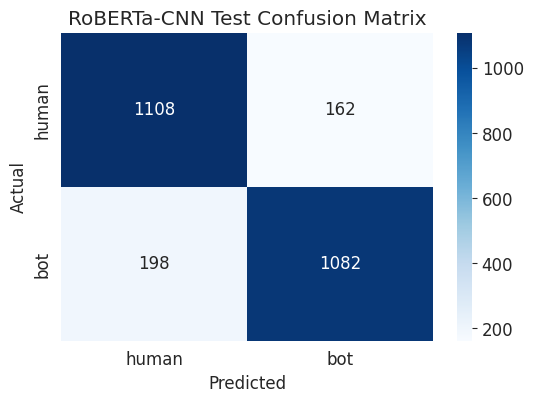

RoBERTa-CNN Test Set - Accuracy: 0.8588, F1: 0.8588, Loss: 0.3793


In [20]:
# --- 11. Run RoBERTa + CNN Hybrid Experiment ---
print("\n\n--- Starting Experiment 4: RoBERTa + CNN Hybrid ---")

best_cnn_hybrid_model_path, cnn_hybrid_training_history_df = train_model_generic(
    model_roberta_cnn,
    train_dataloader_cnn,
    val_dataloader_cnn,
    optimizer_roberta_cnn,
    device,
    epochs=EPOCHS_CNN_HYBRID,
    model_save_path_base_dir=OUTPUT_DIR_ROBERTA_CNN, # Pass output directory
    model_name_prefix="roberta_cnn_hybrid",         # Pass model name prefix
    experiment_name_suffix="RoBERTa-CNN"
)

print("\nRoBERTa-CNN Hybrid Training History:")
print(cnn_hybrid_training_history_df)
# Plot history for cnn_hybrid_training_history_df (similar to how you plotted for LSTM)
# ... (copy plotting code, replace df name)

# Load the best model for testing
if best_cnn_hybrid_model_path and os.path.exists(best_cnn_hybrid_model_path):
    print(f"\nLoading best RoBERTa-CNN Hybrid model from: {best_cnn_hybrid_model_path}")
    model_roberta_cnn.load_state_dict(torch.load(best_cnn_hybrid_model_path))
else:
    print("No best model for RoBERTa-CNN Hybrid was saved/found. Evaluating with the last state.")

print("\n--- Testing RoBERTa-CNN Hybrid on Test Set (with best model) ---")
test_acc_cnn_hybrid, test_f1_cnn_hybrid, test_loss_cnn_hybrid = evaluate_model_generic(
    model_roberta_cnn,
    test_dataloader_cnn,
    device,
    "RoBERTa-CNN Test"
)
print(f"RoBERTa-CNN Test Set - Accuracy: {test_acc_cnn_hybrid:.4f}, F1: {test_f1_cnn_hybrid:.4f}, Loss: {test_loss_cnn_hybrid:.4f}")

In [21]:
df.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human,66
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180


In [22]:
# --- SECTION: Save Final Model and Tokenizer ---
# The best model is already saved with a dynamic name. We just save the tokenizer.
TOKENIZER_SAVE_PATH = os.path.join(OUTPUT_DIR_ROBERTA_CNN, "tokenizer")

print("\n--- Saving final components for analysis ---")

# The tokenizer was defined as 'tokenizer_roberta'
tokenizer_roberta.save_pretrained(TOKENIZER_SAVE_PATH)
print(f"Tokenizer saved to: {TOKENIZER_SAVE_PATH}")


--- Saving final components for analysis ---
Tokenizer saved to: ./roberta_cnn_hybrid_output/tokenizer


In [23]:
# --- Setup and Loading Artifacts for RoBERTa+CNN Model ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import os
import re

# --- 1. Define the Model Architecture (Must match the saved model) ---
class RobertaCNNModel(nn.Module):
    def __init__(self, roberta_model_name, num_classes, num_cnn_filters, cnn_kernel_sizes, cnn_dropout_rate):
        super(RobertaCNNModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=roberta_output_dim, out_channels=num_cnn_filters, kernel_size=ks) 
            for ks in cnn_kernel_sizes
        ])
        self.dropout = nn.Dropout(cnn_dropout_rate)
        self.classifier = nn.Linear(len(cnn_kernel_sizes) * num_cnn_filters, num_classes)
    def forward(self, input_ids, attention_mask, labels=None):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = roberta_outputs.last_hidden_state
        embedded_permuted = sequence_output.permute(0, 2, 1)
        conved = [F.relu(conv(embedded_permuted)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        logits = self.classifier(cat)
        return {"logits": logits}

# --- 2. Load Saved Artifacts ---
OUTPUT_DIR = "./roberta_cnn_hybrid_output"
TOKENIZER_PATH = os.path.join(OUTPUT_DIR, "tokenizer")

# Find the best model file
files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(".pt")]
if not files: raise FileNotFoundError("No model .pt files found!")
files.sort(key=lambda f: float(f.split('_')[-1].replace('.pt', '')), reverse=True)
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, files[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load components
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
model_roberta_cnn = RobertaCNNModel("roberta-base", 2, 100, [3, 4, 5], 0.3)
model_roberta_cnn.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model_roberta_cnn.to(device)
model_roberta_cnn.eval()

print("--- All components for RoBERTa+CNN loaded successfully! ---")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- All components for RoBERTa+CNN loaded successfully! ---


In [24]:
# --- LIME Implementation for RoBERTa+CNN (Corrected and Complete) ---
import lime
import lime.lime_text
import torch.nn.functional as F

# Create a predictor function that LIME can use for the RoBERTa+CNN model
def lime_predictor_roberta_cnn(texts):
    model_roberta_cnn.eval()
    
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    
    # Get model predictions
    with torch.no_grad():
        logits = model_roberta_cnn(inputs['input_ids'], inputs['attention_mask'])["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# Create the LIME explainer
explainer_lime_rc = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

# --- Define the standard text examples for comparison ---
text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

# --- Explanation for BOT-like tweet ---
print("--- LIME Explanation for RoBERTa+CNN on a BOT-like tweet ---")
explanation_bot_rc = explainer_lime_rc.explain_instance(
    text_to_explain_bot, 
    lime_predictor_roberta_cnn, 
    num_features=10
)
# Save the explanation to the correct output directory for this experiment
explanation_bot_rc.save_to_file(os.path.join(OUTPUT_DIR, 'lime_roberta_cnn_bot.html'))
explanation_bot_rc.show_in_notebook(text=True)

# --- Explanation for HUMAN-like tweet (The missing part) ---
print("\n--- LIME Explanation for RoBERTa+CNN on a HUMAN-like tweet ---")
explanation_human_rc = explainer_lime_rc.explain_instance(
    text_to_explain_human, 
    lime_predictor_roberta_cnn, 
    num_features=10
)
# Save the explanation to the correct output directory
explanation_human_rc.save_to_file(os.path.join(OUTPUT_DIR, 'lime_roberta_cnn_human.html'))
explanation_human_rc.show_in_notebook(text=True)

--- LIME Explanation for RoBERTa+CNN on a BOT-like tweet ---



--- LIME Explanation for RoBERTa+CNN on a HUMAN-like tweet ---


**Part 1: Analysis of the LIME Outputs**

Case Study 1: The "Bot-like" Tweet
LIME Prediction: 99% probability of "human".
Words supporting "human": new, check, AI, now, out, my.
Case Study 2: The "Human-like" Tweet
LIME Prediction: 100% probability of "human".
Words supporting "human": cafe, coffee, cozy, at, amazing.

In [29]:
# --- SHAP Implementation for RoBERTa+CNN (Text-Based Approach) ---
import shap
import torch
import numpy as np

# --- 1. Create a custom Model Wrapper for SHAP's Text Explainer ---
class ShapTextModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, texts):
        inputs = self.tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(inputs['input_ids'], inputs['attention_mask'])["logits"]
        return logits.cpu().numpy()

# --- 2. Create the SHAP Explainer ---
# Use the correct model for this experiment: model_roberta_cnn
shap_wrapped_model = ShapTextModelWrapper(model_roberta_cnn, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="[MASK]")
explainer = shap.Explainer(shap_wrapped_model, masker, output_names=['human', 'bot'])

# --- 3. Explain a batch of texts ---
shap_texts = [
    "new post on my blog check it out now #tech #AI #update",
    "Just had the most amazing coffee at this little cafe downtown. So cozy!"
]

print("Running SHAP explanation for RoBERTa+CNN model...")
shap_values = explainer(shap_texts)
print("SHAP explanation complete.")

# --- 4. Generate the Text Force Plots ---
print("\n--- Generating SHAP Text Plots (Explaining the 'bot' class) ---")
shap.plots.text(shap_values[:, :, "bot"])

Running SHAP explanation for RoBERTa+CNN model...
SHAP explanation complete.

--- Generating SHAP Text Plots (Explaining the 'bot' class) ---


Understanding the Force Plot
This plot is a visual representation of a "tug-of-war" for a single prediction.
Base Value (-1.67848): This is the model's starting point. It's the average prediction score (on the log-odds scale) for the "bot" class across the entire background dataset. A negative value means the model has a slight inherent bias towards predicting "human" (Class 0).
Red Arrows (Pushing Higher): These are the words/tokens in the specific tweet that are pushing the prediction towards "bot" (Class 1). The bigger the arrow, the stronger its influence.
Blue Arrows (Pushing Lower): These are the words/tokens pushing the prediction away from "bot" and therefore towards "human" (Class 0).
Final Prediction (f_bot(inputs)): This bold number is the model's final output score. If this number is more positive than the base value, the red forces won. If it's more negative, the blue forces won.
Analysis of Your SHAP Plots
Case Study 1: The "Bot-like" Tweet [0]
Tweet: new post on my blog check it out now #tech #AI #update
Final Prediction (f_bot): -2.86071. This is a very low score, indicating a high-confidence prediction for "human".
Interpretation: This is a misclassification. The model failed to identify this as a bot tweet. The plot tells us precisely why:
"Human" Drivers (Blue): The words update, new, check, and blog are all strongly pushing the model to predict "human". The model has learned from the training data that phrases related to "announcements" are typically human. The CNN head is likely very good at spotting this "new post on my blog" pattern.
"Bot" Drivers (Red): The hashtags (#, #t, #) and the word my are pushing towards "bot". It's interesting that the model correctly sees hashtags as a bot-like feature. However, their influence was completely overwhelmed by the "announcement" pattern.
Thesis Insight: "The SHAP force plot for the AI-generated tweet reveals a specific failure mode of the RoBERTa+CNN model. While it correctly identified the hashtags as a signal for bot activity (red arrows), this was heavily outweighed by its learned association of the phrase 'new post... blog... update' with human language (blue arrows). This indicates that the model, while proficient at detecting local n-gram patterns via its CNN head, can be confidently misled by AI text that mimics common human announcement structures."
Case Study 2: The "Human-like" Tweet [1]
Tweet: Just had the most amazing coffee at this little cafe downtown. So cozy!
Final Prediction (f_bot): -3.02322. This is an extremely low score, indicating a very high-confidence prediction for "human".
Interpretation: This is a correct and highly confident classification.
"Human" Drivers (Blue): The words amazing, coffee, at, and cafe are massive blue arrows, strongly pushing the prediction towards "human". The model has successfully learned that words describing personal, sensory experiences and specific places are powerful indicators of authenticity.
"Bot" Drivers (Red): Words like little, this, the, had, and most are shown in red. This does not mean they are strong bot signals. It's more likely model noise or a learned pattern that very generic, common words sometimes appear in formulaic bot text. Their impact is tiny compared to the powerful blue arrows.
Thesis Insight: "Conversely, the force plot for the authentic human tweet demonstrates the model's strength. The decision was overwhelmingly driven by strong negative SHAP values for words related to sensory experience (amazing, coffee) and specific locations (cafe). This confirms that the model effectively uses the contextual understanding from RoBERTa, enhanced by the CNN's ability to spot these key local phrases, to correctly identify genuine human expression."
By presenting these two plots side-by-side in your thesis, you provide a balanced, evidence-based view of both the strengths and weaknesses of your RoBERTa+CNN architecture.


--- Starting Fine-Grained Analysis for RoBERTa+CNN ---


Making binary predictions:   0%|          | 0/160 [00:00<?, ?it/s]

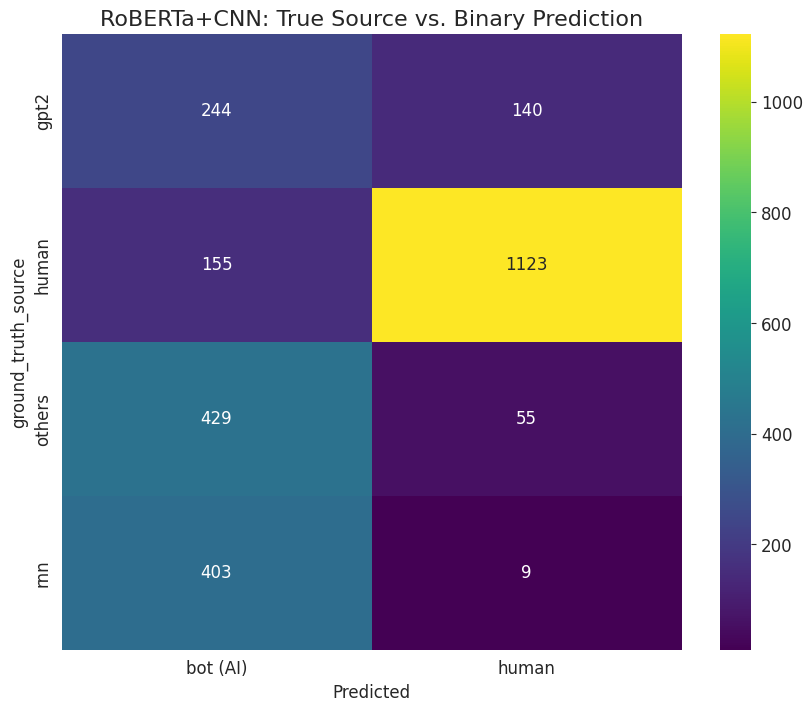


--- Detection Accuracy per AI Generator Source ---
Detection accuracy for 'gpt2': 63.54%
Detection accuracy for 'others': 88.64%
Detection accuracy for 'rnn': 97.82%


In [31]:
# --- SECTION: Multi-class Analysis for RoBERTa+CNN ---
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset

print("\n--- Starting Fine-Grained Analysis for RoBERTa+CNN ---")

# Load test data
dataset_path = '/kaggle/input/tweepfakemsnew' 
df_test = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')
df_test['processed_text'] = df_test['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9@#\' ]+', '', str(x).lower().strip()))
df_test['ground_truth_source'] = df_test['class_type'].fillna('human')

# Create Dataloader
test_encodings = tokenizer(list(df_test['processed_text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset_for_pred = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_dataloader_for_pred = DataLoader(test_dataset_for_pred, batch_size=16)

# Get Predictions
all_binary_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader_for_pred, desc="Making binary predictions"):
        input_ids, attention_mask = [b.to(device) for b in batch]
        logits = model_roberta_cnn(input_ids, attention_mask)["logits"]
        preds = torch.argmax(logits, dim=1)
        all_binary_preds.extend(preds.cpu().numpy())

# Create and Plot Confusion Matrix
predicted_labels = ['human' if p == 0 else 'bot (AI)' for p in all_binary_preds]
cm_df = pd.crosstab(df_test['ground_truth_source'], pd.Series(predicted_labels, name='Predicted'))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis')
plt.title('RoBERTa+CNN: True Source vs. Binary Prediction', fontsize=16)
plt.savefig(os.path.join(OUTPUT_DIR, "fig_roberta_cnn_multiclass_cm.png"))
plt.show()

# Print per-source accuracy
print("\n--- Detection Accuracy per AI Generator Source ---")
df_test['binary_prediction'] = all_binary_preds
class_names = sorted(df_test['ground_truth_source'].unique())
for source_name in class_names:
    if source_name == 'human': continue
    subset_df = df_test[df_test['ground_truth_source'] == source_name]
    accuracy = (subset_df['binary_prediction'] == 1).mean()
    print(f"Detection accuracy for '{source_name}': {accuracy:.2%}")